# PS4

In [10]:
'''
Author: Chittaranjan
'''

'\nAuthor: Chittaranjan\n'

In [11]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
import scipy.stats as st
from collections import defaultdict

from intervals import get_interval_estimate

## Q0 - Topics in Pandas

### Sparse Data Structures
- Pandas provides a way of efficiently storing "sparse" data structures
- A sparse data structure is one in which a majority of the values are
omitted (to be interpreted as 0, or NaN, or any other value)
- It can be thought of as a "compressed" representation, as all values are
not explicitly stored in the data structure

### Creating a Sparse Data Frame
- Sparse data frames can be created using `pd.arrays.SparseArray`
- Has a dtype of `Sparse` which has two values associated with it,
    - Type of non-omitted values (Eg: float, int etc)
    - Value of the elements in the array that aren't actually stored
(Eg: 0, nan)


In [12]:
s = pd.Series(pd.arrays.SparseArray([1] * 2 + [np.nan] * 8))
s

0    1.0
1    1.0
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
dtype: Sparse[float64, nan]

`Sparse[float64, nan]` indicates that all values apart from `nan` are stored,
 and they are of type float.

### Memory Efficiency
- The `memory_usage` function can be used to inspect the number of bytes
being consumed by the Series/DataFrame
- Comparing memory usage between a SparseArray and a regular python list
represented as a Series depicts the memory efficiency of SparseArrays

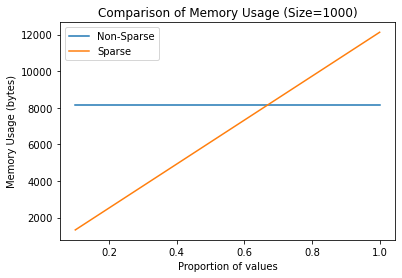

In [13]:
N = 1000  # number of elements to be represented

proportions = list(range(100, N+1, 100))
sparse_mems = []
non_sparse_mems = []
for proportion in proportions:
    sample_list = [14] * proportion + [np.nan] * (N - proportion)
    sparse_arr = pd.Series(
        pd.arrays.SparseArray(sample_list)
    )
    sparse_mem = sparse_arr.memory_usage()
    sparse_mems.append(sparse_mem)

    non_sparse_arr = pd.Series(sample_list)
    non_sparse_mem = non_sparse_arr.memory_usage()
    non_sparse_mems.append(non_sparse_mem)

x = list(map(lambda p: p / N, proportions))
_ = plt.plot(x, non_sparse_mems)
_ = plt.plot(x, sparse_mems)
_ = plt.ylabel("Memory Usage (bytes)")
_ = plt.xlabel("Proportion of values")
_ = plt.legend(["Non-Sparse", "Sparse"])
_ = plt.title("Comparison of Memory Usage (Size=1000)")

### Memory Efficiency (Continued)
- The Sparse Arrays consume much less memory when the density is low
(sparse-ness is high)
- As the density increases to where 50-60% of the values are not nan
(i.e ommittable), memory efficiency is worse

## Q1 - NHANES Table

### Q1 (a) -- Done in PS2, not shown here

In [14]:
DEMOGRAPHICS_PKL = "demographics.pickle"
DENTITION_PKL = "dentition.pickle"
assert exists(DEMOGRAPHICS_PKL)
assert exists(DENTITION_PKL)

### Q1 (b) -- Merge

In [15]:
demographics_df = pd.read_pickle(DEMOGRAPHICS_PKL)
demographics_df["education"] = demographics_df["education"].str.lower()
demographics_df = demographics_df.astype({"education": str})
dentition_df = pd.read_pickle(DENTITION_PKL)
merged = demographics_df.merge(
    dentition_df[["id", "ohx_status"]],
    on="id",
    how="left"
)

In [16]:
source_cols = ["id", "age", "gender", "exam_status", "ohx_status", "education"]
clean_df = pd.DataFrame()
clean_df[source_cols] = merged[source_cols]
clean_df["under_20"] = merged[["age"]].applymap(lambda a: a < 20)

In [17]:
conditions = [
    (~merged["education"].str.contains("college")),
    (merged["age"] < 20),
    (merged["education"].str.contains("college"))
]
values = [
    "no college/<20",
    "no college/<20",
    "some college/college graduate"
]
clean_df["college"] = np.select(conditions, values)
clean_df = clean_df.drop(columns=["education"], axis=1)
clean_df = clean_df.astype({"college": "category"})

In [18]:
clean_df[clean_df["under_20"]].shape

(16539, 7)

### Q1 (c) -- Filter out rows with exam status != 2

In [19]:
conditions = [
    (
        (clean_df["exam_status"].str.contains("Both")) &
        (clean_df["ohx_status"] == "Complete")),
    (clean_df["ohx_status"] != "Complete"),
]
values = [
    "Complete",
    "Missing"
]
clean_df["ohx"] = np.select(conditions, values)
clean_df = clean_df.astype({"ohx": "category"})

In [20]:
clean_df[clean_df["exam_status"] != "Both interviewed and MEC examined"].shape

(1757, 8)

Number of rows where `exam_status != 2` is `1757` (rows to be removed)

In [21]:
clean_df.shape

(39156, 8)

Number of total rows is `39156`

In [22]:
clean_df = clean_df[~(clean_df["exam_status"] !=
                      "Both interviewed and MEC examined")]

In [23]:
clean_df.shape

(37399, 8)

Number of rows remaining after `1757` rows are removed is `37399`

### Q1 (d) -- Table 1

In [24]:
# Pick out Missing & Complete subsets of data
missing = clean_df[clean_df["ohx"] == "Missing"]
complete = clean_df[clean_df["ohx"] == "Complete"]

In [25]:
# Compute total counts across categorical variables (for % computation)
males = clean_df[clean_df["gender"] == "Male"].shape[0]
females = clean_df[clean_df["gender"] == "Female"].shape[0]
under_20_no = clean_df[clean_df["under_20"] == False].shape[0]
under_20_yes = clean_df[clean_df["under_20"] == True].shape[0]
college_no = clean_df[clean_df["college"] == "no college/<20"].shape[0]
college_yes = clean_df[clean_df["college"] != "no college/<20"].shape[0]

In [26]:
# Count ohx=Complete and under_20=False
complete_under_20_no = complete[complete["under_20"] == False].shape[0]
complete_under_20_no_pct = round(
    (complete_under_20_no / under_20_no) * 100, 2
)

# Count ohx=Complete and under_20=True
complete_under_20_yes = complete[complete["under_20"] == True].shape[0]
complete_under_20_yes_pct = round(
    (complete_under_20_yes / under_20_yes) * 100, 2
)

In [27]:
# Count ohx=Missing and under_20=False
missing_under_20_no = missing[missing["under_20"] == False].shape[0]
missing_under_20_no_pct = round((missing_under_20_no / under_20_no) * 100, 2)

# Count ohx=Missing and under_20=True
missing_under_20_yes = missing[missing["under_20"] == True].shape[0]
missing_under_20_yes_pct = round(
    (missing_under_20_yes / under_20_yes) * 100, 2
)

In [28]:
# Count ohx=Complete and gender="Male"
complete_male = complete[complete["gender"] == "Male"].shape[0]
complete_male_pct = round((complete_male / males) * 100, 2)

# Count ohx=Complete and gender="Female"
complete_female = complete[complete["gender"] == "Female"].shape[0]
complete_female_pct = round((complete_female / females) * 100, 2)

In [29]:
# Count ohx=Missing and gender="Male"
missing_male = missing[missing["gender"] == "Male"].shape[0]
missing_male_pct = round((missing_male / males) * 100, 2)

# Count ohx=Missing and gender="Female"
missing_female = missing[missing["gender"] == "Female"].shape[0]
missing_female_pct = round((missing_female / females) * 100, 2)

In [30]:
# Count ohx=Complete and college="no college/<20"
complete_college_no = complete[
    complete["college"] == "no college/<20"
].shape[0]
complete_college_no_pct = round(
    (complete_college_no / college_no) * 100, 2
)

# Count ohx=Complete and college!="no college/<20"
complete_college_yes = complete[
    complete["college"] != "no college/<20"
].shape[0]
complete_college_yes_pct = round(
    (complete_college_yes / college_yes) * 100, 2
)

In [31]:
# Count ohx=Missing and college="no college/<20"
missing_college_no = missing[missing["college"] == "no college/<20"].shape[0]
missing_college_no_pct = round((missing_college_no / college_no) * 100, 2)

# Count ohx=Missing and college!="no college/<20"
missing_college_yes = missing[missing["college"] != "no college/<20"].shape[0]
missing_college_yes_pct = round((missing_college_yes / college_yes) * 100, 2)

In [32]:
# Compute Mean and SD for age
complete_age_mean = round(complete["age"].mean(), 1)
complete_age_std = round(complete["age"].std(), 1)
missing_age_mean = round(missing["age"].mean(), 1)
missing_age_std = round(missing["age"].std(), 1)

In [33]:
# Compute p-values for t-test and chi-square tests
age_p = "{:0.2e}".format(st.ttest_ind(missing["age"], complete["age"]).pvalue)

under_20_chi_p = "{:0.2e}".format(
    st.chi2_contingency(
        [
            [complete_under_20_no, missing_under_20_no],
            [complete_under_20_yes, missing_under_20_yes]
        ]
    )[1]
)

gender_chi_p = "{:0.2e}".format(
    st.chi2_contingency(
        [
            [complete_female, missing_female],
            [complete_male, missing_male]
        ]
    )[1]
)

college_chi_p = "{:0.2e}".format(
    st.chi2_contingency(
        [
            [complete_college_no, missing_college_no],
            [complete_college_yes, missing_college_yes]
        ]
    )[1]
)

In [34]:
# Build summary table
summary_table = [
    [
        f"[{complete_age_mean} ({complete_age_std})]",
        f"[{missing_age_mean} ({missing_age_std})]",
        age_p
    ],
    [
        f"{complete_under_20_no} ({complete_under_20_no_pct}%)",
        f"{missing_under_20_no} ({missing_under_20_no_pct}%)",
        under_20_chi_p
    ],
    [
        f"{complete_under_20_yes} ({complete_under_20_yes_pct}%)",
        f"{missing_under_20_yes} ({missing_under_20_yes_pct}%)",
        "-"
    ],
    [
        f"{complete_female} ({complete_female_pct}%)",
        f"{missing_female} ({missing_female_pct}%)",
        gender_chi_p
    ],
    [
        f"{complete_male} ({complete_male_pct}%)",
        f"{missing_male} ({missing_male_pct}%)",
        "-"
    ],
    [
        f"{complete_college_no} ({complete_college_no_pct}%)",
        f"{missing_college_no} ({missing_college_no_pct}%)",
        college_chi_p
    ],
    [
        f"{complete_college_yes} ({complete_college_yes_pct}%)",
        f"{missing_college_yes} ({missing_college_yes_pct}%)",
        "-"
    ],
]

In [35]:
# Create a tuple to be used for creating a multi-index
index_tuples = [
    ("Age", ""),
    ("Under 20", "No"),
    ("Under 20", "Yes"),
    ("Gender", "Female"),
    ("Gender", "Male"),
    ("College", "None or < 20 years old"),
    ("College", "Some College or Graduate")
]

In [36]:
index = pd.MultiIndex.from_tuples(index_tuples, names=["Variable", "Group"])
table_1 = pd.DataFrame(
    summary_table,
    columns=["Complete", "Missing", "p-value"],
    index=index
)

In [37]:
table_1

Complete        Missing    p-value
Variable Group                                                             
Age                                 [33.2 (24.4)]  [22.0 (26.6)]  1.77e-126
Under 20 No                         20369 (94.1%)    1277 (5.9%)   4.96e-76
         Yes                       13991 (88.81%)  1762 (11.19%)          -
Gender   Female                    17342 (91.43%)   1626 (8.57%)   1.44e-03
         Male                      17018 (92.33%)   1413 (7.67%)          -
College  None or < 20 years old    22974 (90.45%)   2427 (9.55%)   6.98e-49
         Some College or Graduate   11386 (94.9%)     612 (5.1%)          -

Table 1: Summary of Complete and Missing Dental exams with
corresponding p-values

## Q2 - Monte Carlo Comparison

### Q2 (a),  Q2 (b) -- Contour Plots (combined with a utility function) 

In [38]:
def calc_num_simulations(p, mc_conf_level=0.95, error=0.005):
    """
    Calculates the number of Monte Carlo simulations required

    Parameters
    ----------
    p : float
        Population proportion for the data.
    mc_conf_level : float, optional
        Confidence level for the MC Estimate. The default is 0.95.
    error : float, optional
        The error threshold for the MC estimate. The default is 0.005.

    Returns
    -------
    int
        Minimum number of Monte Carlo simulation required to be run.

    """
    alpha = 1 - mc_conf_level
    z = st.norm.ppf(1 - (alpha / 2))
    std = np.sqrt(p * (1 - p))
    return int((z * (std / error)) ** 2)

In [39]:
def create_dataset(n, p, N):
    """
    Creates a dataset from the binomial distribution

    Parameters
    ----------
    n : int
        Sample size for each record of the data.
    p : float
        Probability of success, as defined in the binomial dist.
    N : int
        Number of records to generate.

    Returns
    -------
    ndarray
        Dataset of 0s and 1s, generated from a binomial distribution.

    """
    return np.random.binomial(1, p, n * N).reshape(N, n)

In [40]:
def run_monte_carlo(n, p, method, conf_level=0.9):
    """
    Runs a Monte Carlo simulation and computes the width and confidence level
    of the CI method

    Parameters
    ----------
    n : int
        Sample size.
    p : float
        Population proportion.
    method : str
        A function that is to be invoked to compute the interval. Can be one
        of ("normal", "normal-binomial", "clopper-pearson", "jeffreys", 
            "agresti-coull")
    Returns
    -------
    result : dict
        Keys "width" and "level" contain the average width and level for 
        the method.

    """
    N = calc_num_simulations(p)
    dataset = create_dataset(n, p, N)
    result = defaultdict(lambda: 0)
    for sample in dataset:
        statistic = get_interval_estimate(
            sample,
            conf_level * 100,
            method,
            output_format=None
        )
        lwr, upr = statistic["lwr"], statistic["upr"]
        result["width"] += (upr - lwr) / N
        result["level"] += int(lwr < p < upr) / N
    return result

In [41]:
def run_all(n_options, p_options, methods):
    """
    Triggers a sequence of Monte Carlo simulations for a sequence of n's, p's
    and different CI methods

    Parameters
    ----------
    n_options : arraylike
        A sequence of options to use as n in the MC simulation.
    p_options : arraylike
        A sequence of option to use as p in the MC simulation.
    methods : arraylike
        A sequence of strings containing CI methods. Supported for 
        "normal", "normal-binomial", "clopper-pearson", "jeffreys", 
        "agresti-coull"

    Returns
    -------
    all_results : dict
        Keys with each CI method and values with four lists containing n's, p's
        levels, and widths

    """
    all_results = defaultdict(lambda: [[], [], [], []])
    for n in n_options:
        for p in p_options:
            for method in methods:
                result = run_monte_carlo(n, p, method)
                all_results[method][0].append(n)
                all_results[method][1].append(p)
                all_results[method][2].append(result["level"])
                all_results[method][3].append(result["width"])
    return all_results

In [42]:
results = run_all(
    list(range(100, 501, 100)),
    list(map(lambda x: x / 100, range(20, 50, 10))),
    [
        "normal",
        "agresti-coull",
        "jeffreys",
        "normal-binomial",
        "clopper-pearson"
    ]
)

/Users/chittaranjan/Documents/UM/Fall-21/Stats507/PS4/intervals.py:132: UserWarning: This approximation may not be adequate for the given data
  warnings.warn(


In [43]:
def make_contour(results, metric="level", relative=False):
    """
    Utility function to generate 2d and 3d contour plots

    Parameters
    ----------
    results : dict
        The result returned from the run_all, storing the avg levels and 
        widths for all CI methods.
    metric : string, optional
        Can be either of "level" or "width". This decides which metric 
        the contour plots are built against. The default is "level".
    relative : bool, optional
        This decides whether the plots are built relative to the 
        Clopper-Pearson method. The default is False.

    Returns
    -------
    fig : mpl figure
        Figure object which has the required subplots.

    """
    fig = plt.figure(figsize=(15, 30))
    plt.tight_layout
    n_rows = len(results)
    n_cols = 2
    reference = np.asarray(
        results["clopper-pearson"][2 + int(metric == "width")]
    )
    for idx, method in enumerate(results):
        if relative and method == "clopper-pearson":
            continue
        ax_2d = fig.add_subplot(n_rows, n_cols, (2 * idx) + 1)
        ax_2d.set_title(method.capitalize() + " (2-D)")
        ax_3d = fig.add_subplot(
            n_rows, n_cols, (2 * idx) + 2,
            projection="3d"
        )
        ax_3d.set_title(method.capitalize() + " (3-D)")

        x, y, z1, z2 = results[method]
        z = z1 if metric == "level" else z2
        z = z if not relative else np.divide(np.asarray(z), reference)
        uniq_x, uniq_y = set(x), set(y)
        ax_2d.contour(
            sorted(list(uniq_x)),
            sorted(list(uniq_y)),
            np.asarray(z).reshape(len(uniq_y), len(uniq_x)),
            cmap='plasma'
        )
        ax_2d.set_xlabel("Sample Size")
        ax_2d.set_ylabel("Population Proportion")

        ax_3d.plot_trisurf(
            x,
            y,
            z,
            cmap='plasma',
            edgecolor='black'
        )
        if metric == "level":
            ax_3d.set_zlim([0.85, 0.95])
        ax_3d.set_xlim([min(x) - 50, max(x) + 50])
        ax_3d.set_ylim([min(y) - 0.05, max(y) + 0.05])
        ax_3d.view_init(20, 50)
        ax_3d.set_xlabel("Sample Size")
        ax_3d.set_ylabel("Population Proportion")
        ax_3d.set_zlabel("Confidence " + metric.capitalize())
    return fig

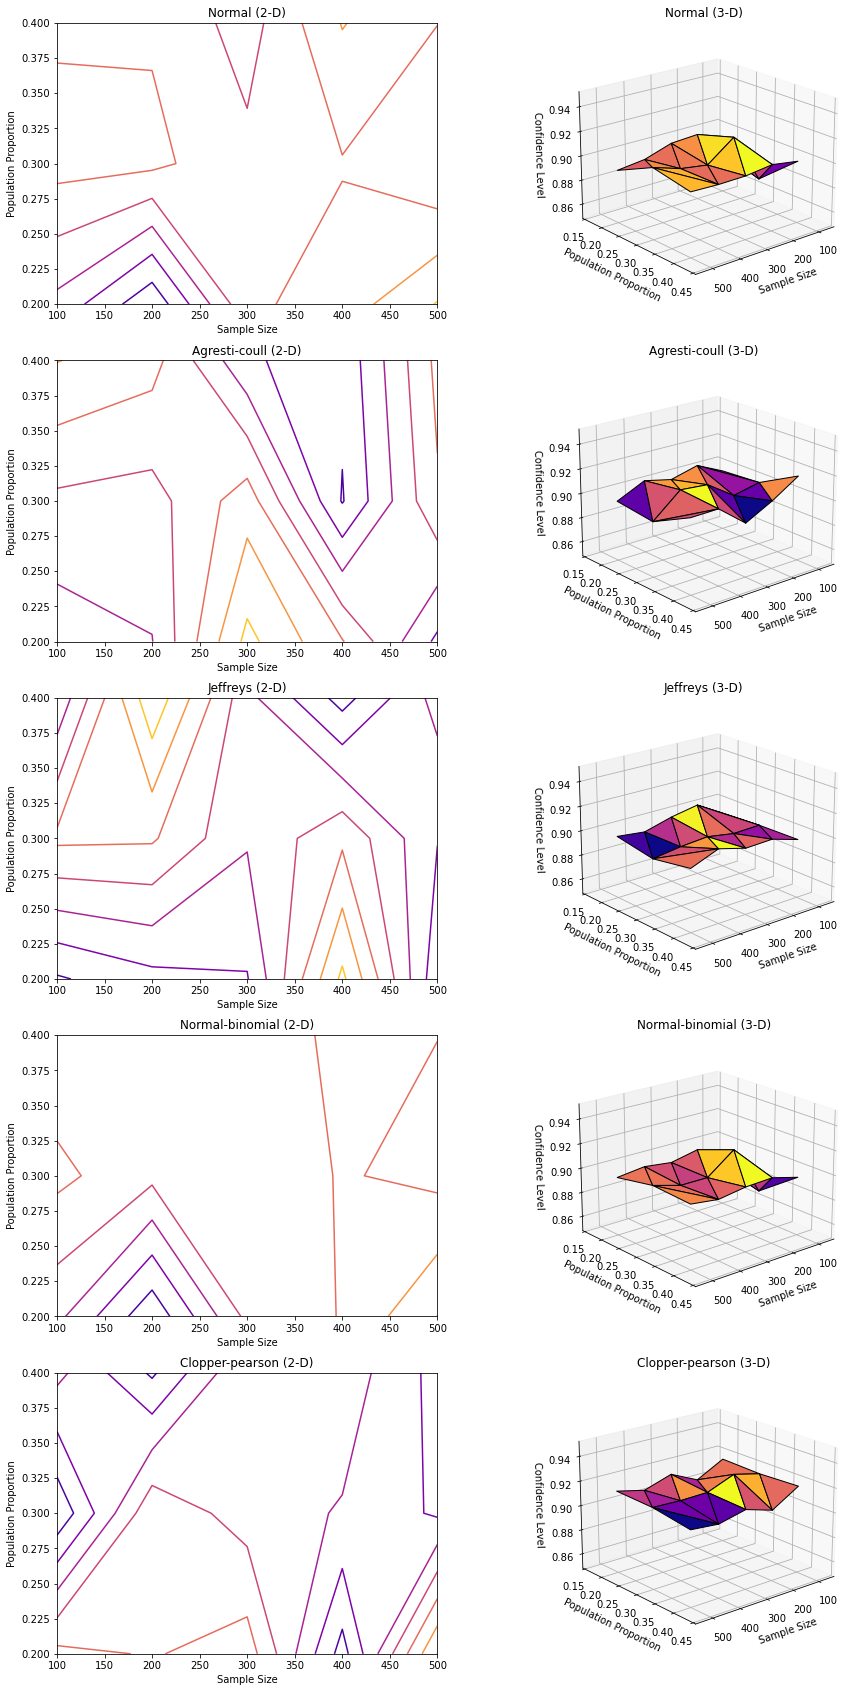

In [44]:
fig1 = make_contour(results, metric="level")

Figure 1: Contour Plots for Confidence Levels across CI Methods

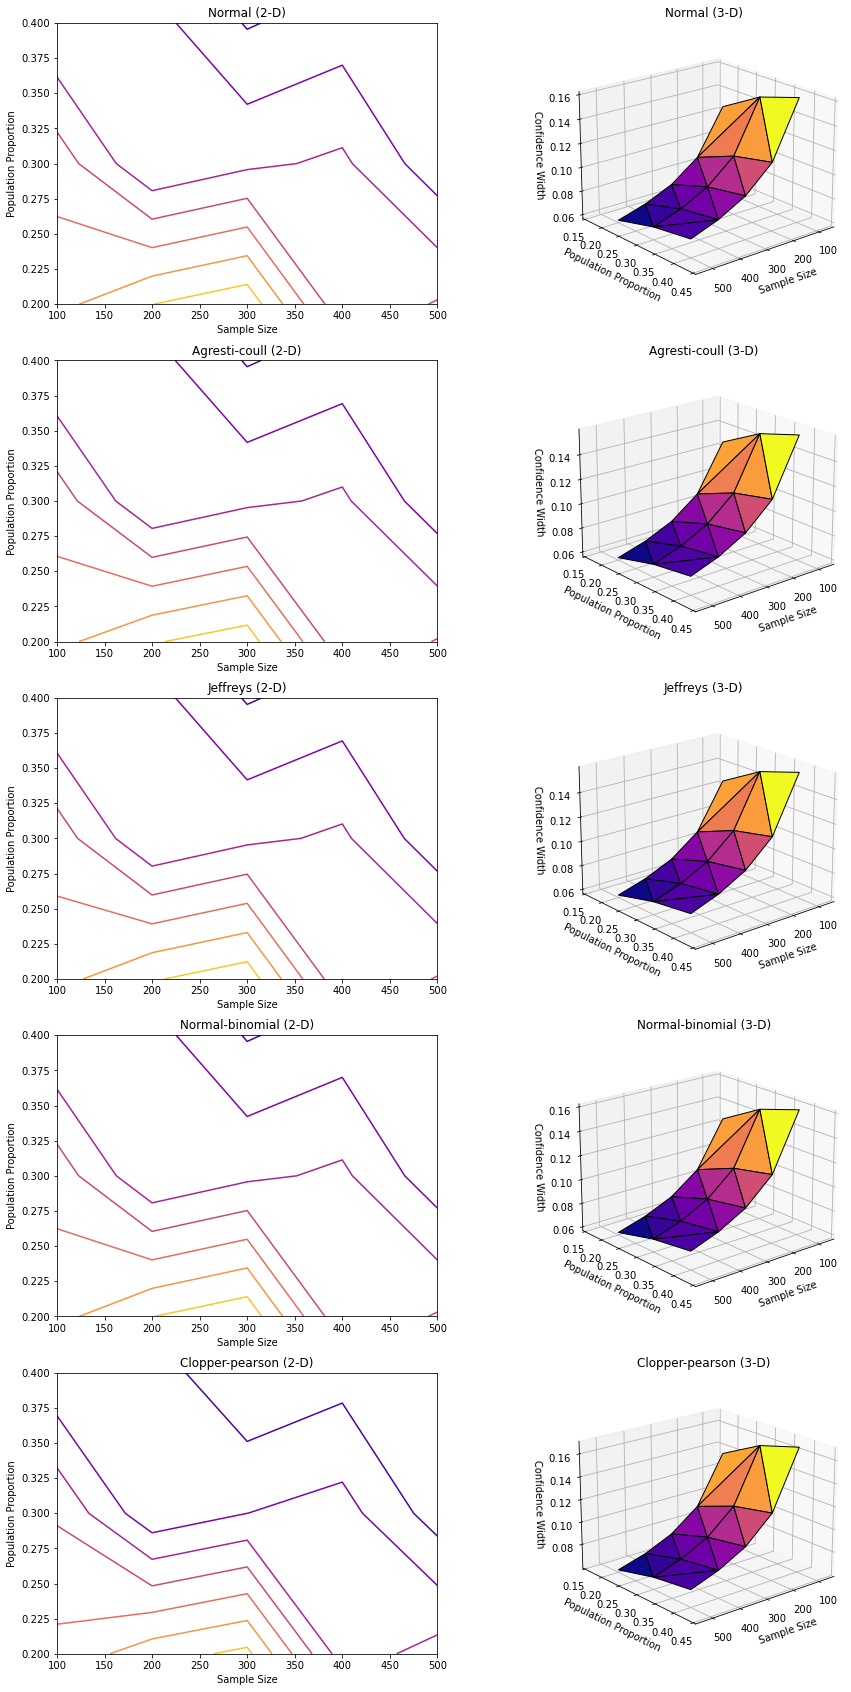

In [45]:
fig2 = make_contour(results, metric="width")

Figure 2: Contour Plots for Confidence Widths across Methods

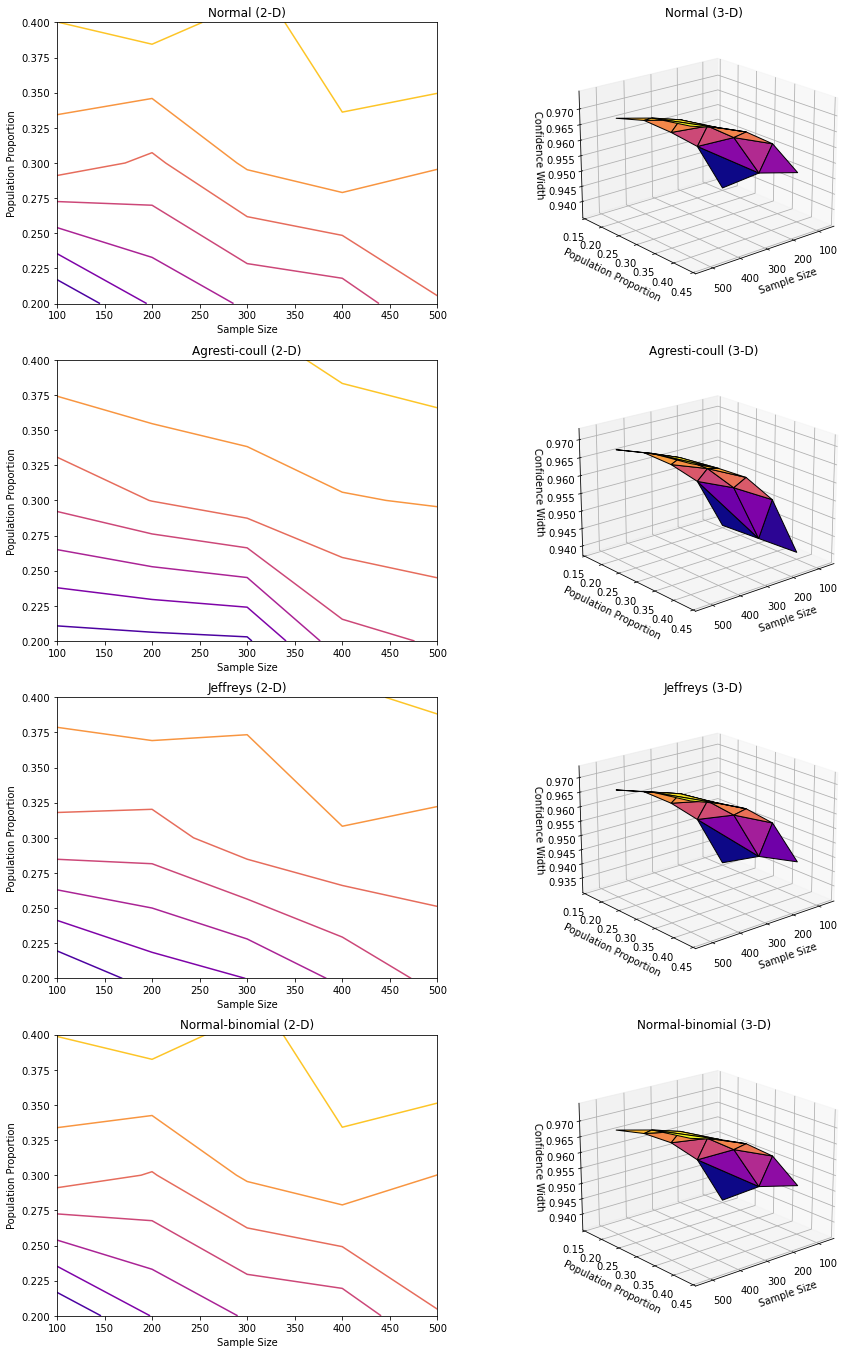

In [46]:
fig3 = make_contour(results, metric="width", relative=True)

Figure 3: Contour Plots for Confidence Widths Relative to Clopper-Pearson